In [19]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [6]:
# --- Step 1: Load News Data ---
# Replace with your actual file name if different
df_news = pd.read_csv('df_nyt_sample.csv', parse_dates=['date'])
df_news.columns

Index(['date', 'year', 'month', 'day', 'author', 'title', 'article', 'url',
       'section', 'publication', 'url_short'],
      dtype='object')

In [4]:
# --- Step 2: Load Industrial Production Index from FRED ---
# donwload data from fred.st.louisfed.org
indpro_path = 'https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23ebf3fb&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1320&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=INDPRO&scale=left&cosd=1919-01-01&coed=2025-03-01&line_color=%230073e6&link_values=false&line_style=solid&mark_type=none&mw=3&lw=3&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2025-05-13&revision_date=2025-05-13&nd=1919-01-01'
df_indpro = pd.read_csv(indpro_path, parse_dates=['observation_date'])
df_indpro.rename(columns={'observation_date': 'date', 'INDPRO': 'ipi'}, inplace=True)


In [7]:
# --- Step 3: Merge News with IPI ---
# Round news dates to month for alignment
df_news['month'] = df_news['date'].dt.to_period('M').dt.to_timestamp()
df_indpro['month'] = df_indpro['date'].dt.to_period('M').dt.to_timestamp()

# Aggregate articles by month (e.g., join content into one document per month)
df_monthly_news = df_news.groupby('month')['article'].apply(lambda x: ' '.join(x.dropna())).reset_index()

# Merge with IPI
df_merged = pd.merge(df_monthly_news, df_indpro[['month', 'ipi']], on='month')
print(f"Merged dataset shape: {df_merged.shape}")

Merged dataset shape: (52, 3)


In [10]:
# --- Step 4: Pre-filter Articles by Topic ---
topic_keywords = [
    "manufacturing", "factory", "production", "industry", "output",
    "supply chain", "logistics", "transport", "shortage",
    "energy", "gas", "oil", "electricity", "utilities",
    "labor", "strike", "employment", "hiring", "wages",
    "policy", "subsidy", "tariff", "regulation",
    "trade", "export", "import", "demand", "inventory",
    "investment", "capex", "spending", "automation", "technology"
]

def filter_keywords(text, keywords):
    text = text.lower()
    return ' '.join([word for word in text.split() if any(k in word for k in keywords)])

df_merged['filtered_content'] = df_merged['article'].apply(lambda x: filter_keywords(x, topic_keywords))

In [13]:
# --- Step 5: Feature Extraction with TF-IDF ---
# Text cleaning function
def clean_text(text_input):
    text_input = text_input.lower()
    text_input = re.sub(r'\d+', '', text_input)  # Remove digits
    text_input = re.sub(f"[{re.escape(string.punctuation)}]", '', text_input)  # Remove punctuation
    text_input = re.sub(r'\s+', ' ', text_input).strip()  # Normalize spaces
    return text_input

# TF-IDF with preprocessing
vectorizer = TfidfVectorizer(
    max_df=0.95,
    min_df=10,
    stop_words='english',
    token_pattern=r'\b[a-zA-Z]{3,}\b',
    preprocessor=clean_text
)

# Generate feature matrix
X = vectorizer.fit_transform(df_merged['filtered_content'].fillna(''))

# Define outcome variable y
y = df_merged['ipi'].values

In [14]:
# --- Step 6: Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [15]:
# --- Step 7: Train Model ---
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)


Ridge()

In [16]:
# --- Step 8: Predict and Evaluate ---
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse:.2f}")

RMSE: 4.94


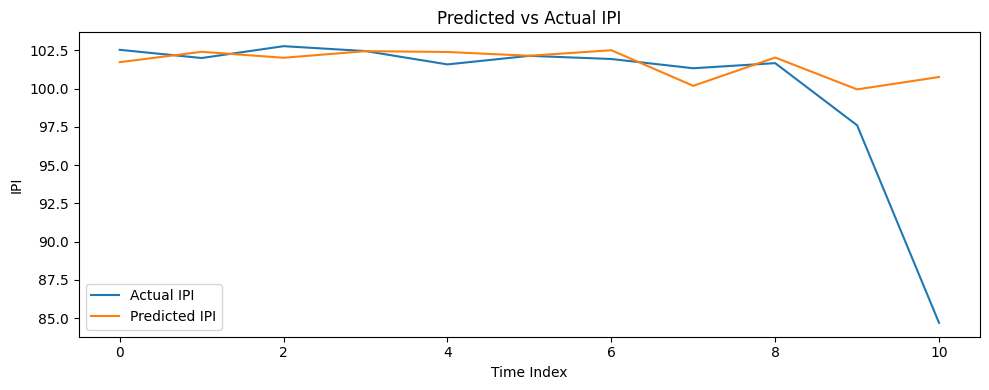

In [17]:
# --- Step 9: Plot Results ---
plt.figure(figsize=(10, 4))
plt.plot(range(len(y_test)), y_test, label='Actual IPI')
plt.plot(range(len(y_pred)), y_pred, label='Predicted IPI')
plt.title('Predicted vs Actual IPI')
plt.xlabel('Time Index')
plt.ylabel('IPI')
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
# Use various Models for Prediction Task

# Dictionary of models to try
models = {
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "SVR": SVR(kernel='rbf', C=1.0, epsilon=0.2)
}

# Train and evaluate each model
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    results[name] = rmse
    print(f"{name} RMSE: {rmse:.3f}")


Ridge RMSE: 4.936
Lasso RMSE: 4.753
Random Forest RMSE: 4.845
Gradient Boosting RMSE: 4.834
SVR RMSE: 4.899


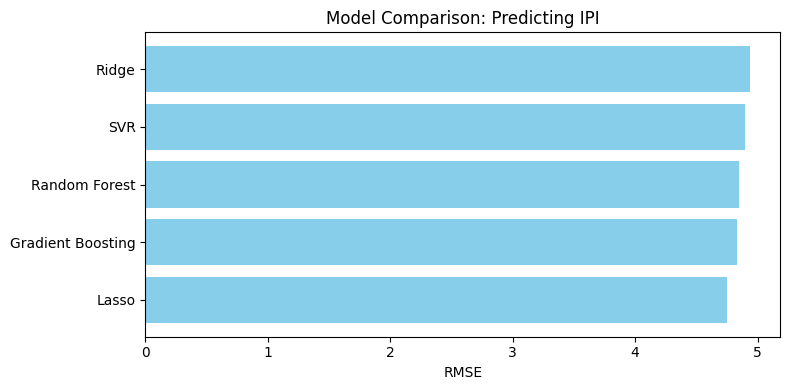

In [21]:
# Sort results
sorted_results = dict(sorted(results.items(), key=lambda item: item[1]))

plt.figure(figsize=(8, 4))
plt.barh(list(sorted_results.keys()), list(sorted_results.values()), color='skyblue')
plt.xlabel("RMSE")
plt.title("Model Comparison: Predicting IPI")
plt.tight_layout()
plt.show()